## Import Packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import pickle
import os
np.set_printoptions(threshold=np.nan)

%matplotlib inline

## Camera Calibration

In [2]:
nx = 9
ny = 6
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

In [3]:
import pickle

img = cv2.imread('test_images/test0_0.jpg')
img_size = (img.shape[1], img.shape[0])

def CameraCalibration(objpoints, imgpoints, img_size):

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    
    return ret, mtx, dist, rvecs, tvecs

    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)

ret, mtx, dist, rvecs, tvecs = CameraCalibration(objpoints, imgpoints, img_size)    
    
dist_pickle = {}
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open("camera_cal/camera_cal.p", "wb"))

## Distortion Correction

In [4]:
def DistortionCorrection(img, mtx, dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

## Color and Gradient Threshold

In [5]:
def abs_sobel_thresh(image, channel = 'gray', orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    if channel == 'gray':
        img = grayscale(image)
    elif channel == 'sat':
        img = s_channel(image)
        
    if orient == 'x':
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0)
        abs_sobel = np.absolute(sobelx)
    elif orient == 'y':
        sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1)
        abs_sobel = np.absolute(sobely)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def mag_thresh_binary(image, channel = 'gray', sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    if channel == 'gray':
        img = grayscale(image)
    elif channel == 'sat':
        img = s_channel(image)
        
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0 , 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(image, channel = 'gray', sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    if channel == 'gray':
        img = grayscale(image)
        
    elif channel == 'sat':
        img = s_channel(image)
        
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    dirgrad = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(dirgrad)
    dir_binary[(dirgrad >= thresh[0]) & (dirgrad <= thresh[1])] = 1
    return dir_binary

def s_channel(image):
    img = np.copy(image)
    hsv = cv2. cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    return s_channel

def grayscale(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return gray
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

def combined_grad(image, sat, ksize, thresh, mag_thresh, dir_binary):
# Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, channel = 'sat', orient='x', sobel_kernel=ksize, thresh=(50, 175))
    grady = abs_sobel_thresh(image, channel = 'sat', orient='y', sobel_kernel=ksize, thresh=(50, 175))
    mag_binary = mag_thresh_binary(image, channel = 'sat', sobel_kernel=ksize, mag_thresh=(50,175))
    dir_binary = dir_threshold(image, channel = 'sat', sobel_kernel=ksize, thresh=(0.7, 1.3))

    gradx_gray = abs_sobel_thresh(image, channel = 'gray', orient='x', sobel_kernel=ksize, thresh=(50, 175))
    grady_gray = abs_sobel_thresh(image, channel = 'gray', orient='y', sobel_kernel=ksize, thresh=(50, 175))
    mag_binary_gray = mag_thresh_binary(image, channel = 'gray', sobel_kernel=ksize, mag_thresh=(50, 175))
    dir_binary_gray = dir_threshold(image, channel = 'gray', sobel_kernel=ksize, thresh=(0.7, 1.3))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | ((gradx_gray == 1) & (grady_gray == 1)) | ((mag_binary_gray == 1) & (dir_binary_gray == 1))] = 1
    
    return combined




## Region of Interest Mask

In [6]:
def region_of_interest(image, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(image)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(image.shape) > 2:
        channel_count = image.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image, mask



## Hough Transform

In [7]:
def Hough_Trans(image, rho, theta, threshold, min_line_len, max_line_gap, center, line_image):
    
    image = np.uint8(255*image/np.max(image))
    lines = cv2.HoughLinesP(image, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    l_lines_x = []
    r_lines_x = []
    l_lines_y = []
    r_lines_y = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
            if (x1 < center) & (x2 < center):
                l_lines_x.append(x1)
                l_lines_y.append(y1)
                l_lines_x.append(x2)
                l_lines_y.append(y2)
            elif (x1 > center) & (x2 > center):
                r_lines_x.append(x1)
                r_lines_y.append(y1)
                r_lines_x.append(x2)
                r_lines_y.append(y2)
    if len(l_lines_x)>0:            
        left_lane_line = np.polyfit(l_lines_x,l_lines_y,1) #left_lane_line = [m,b]
    else: 
        left_lane_line = [0,0]
    
    if len(r_lines_x)>0:
        right_lane_line = np.polyfit(r_lines_x,r_lines_y,1) #rightt_lane_line = [m,b]
    else: 
        right_lane_line = [0,0]
    
    return left_lane_line, right_lane_line, line_image




In [8]:
def source():
    
    src = np.float32([(190, 720), (548, 480), (740, 480), (1130, 720)])
    dst = np.float32([(190, 720), (190, 0), (1130, 0), (1130, 720)])
        
    return src, dst

## Perspective Transform

In [9]:
def corners_unwarp(img, src, dst, mtx, dist, img_size):
    

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)

    # Return the resulting image and matrix
    return warped, M, Minv


## Histogram

In [10]:
import numpy as np
np.set_printoptions(threshold=np.nan)

def find_lines(top_down):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(top_down[top_down.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((top_down, top_down, top_down))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint


    # Choose the number of sliding windows
    nwindows = 7
    # Set height of windows
    window_height = np.int(top_down.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = top_down.nonzero() # Return the indices of the elements that are non-zero.
    nonzeroy = np.array(nonzero[0]) #array of y-coordinates of non zero elements of top_down
    nonzerox = np.array(nonzero[1]) #corresponding array of x-coordinates of non zero elements of top_down
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        #Identify window boundaries in x and y (and right and left)
        win_y_low = top_down.shape[0] - (window+1)*window_height 
        win_y_high = top_down.shape[0] - window*window_height #closer to bottom of frame
        win_xleft_low = leftx_current - margin #left side of left box
        win_xleft_high = leftx_current + margin #right side of left box
        win_xright_low = rightx_current - margin #left side of right box
        win_xright_high = rightx_current + margin
        #Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low),(win_xleft_high, win_y_high),(0,255,0),5)
        cv2.rectangle(out_img, (win_xright_low, win_y_low),(win_xright_high, win_y_high),(0,255,0),5)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return  left_fit, right_fit, leftx, lefty, rightx, righty, out_img
    plt.imshow(out_img)
    #plt.plot(histogram)

## Print Line of Best Fit with Left and Right Lane Pixels

In [11]:
def linefit(top_down, left_fit, right_fit):
    ploty = np.linspace(0, top_down.shape[0]-1, top_down.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return ploty, left_fitx, right_fitx


#out_img[lefty, leftx] = [255, 0, 0]
#out_img[righty, rightx] = [0, 0, 255]
#plt.plot(left_fitx, ploty, color='yellow')
#plt.plot(right_fitx, ploty, color='yellow')
#plt.xlim(0, 1280)
#plt.ylim(720, 0)
#plt.imshow(out_img)
#print(out_img.max())


## Measuring Curvature and Offset

### Curvature

In [12]:
def Curvature(ploty, leftx, rightx):    
    y_eval = np.max(ploty)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #radius = (left_curverad+right_curverad)/2 
    #print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    
    return left_curverad, right_curverad 

### Offset

In [13]:
def Offset(top_down):
    
    histogram = np.sum(top_down[top_down.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((top_down, top_down, top_down))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    midlane = (leftx_base+rightx_base)/2
    midcar = (top_down.shape[1])/2
    px_2_m = 0.004111
    
    offset = px_2_m*(np.absolute(midlane-midcar))
    
    return offset

## Make Radius and Offset Caption


In [14]:
def Caption(result, offset_dist, l_radius, r_radius):
    font = cv2.FONT_HERSHEY_SIMPLEX
    offset_str = str('offset from center: '+str(offset_dist*100)+'cm')
    cv2.putText(result,offset_str,(20,30), font, 1,(255,255,255),2,cv2.LINE_AA)
    if l_radius and r_radius:
        radius = round((l_radius/1000+r_radius/1000)/2,1) 
        str2 = str('radius of curvature: '+str(radius)+'km')
        cv2.putText(result,str2,(20,60), font, 1,(255,255,255),2,cv2.LINE_AA)    

## Drawing

In [15]:
image = mpimg.imread('signs_vehicles_xygrad.png')
#image = image.astype(np.uint8)

def drawing(image, top_down, left_fitx, right_fitx, ploty, Minv):
# Create an image to draw the lines on
    warp_zero = np.zeros_like(top_down).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    newwarp = newwarp.astype(dtype = np.uint8)
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    return result

    fig, ax = plt.subplots(figsize=(24, 9))
    ax.imshow(result)

## Loop Through All Test Images and Save

In [16]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [17]:
import os
import numpy as np
np.set_printoptions(threshold=np.nan)
test_list = os.listdir("test_images/")

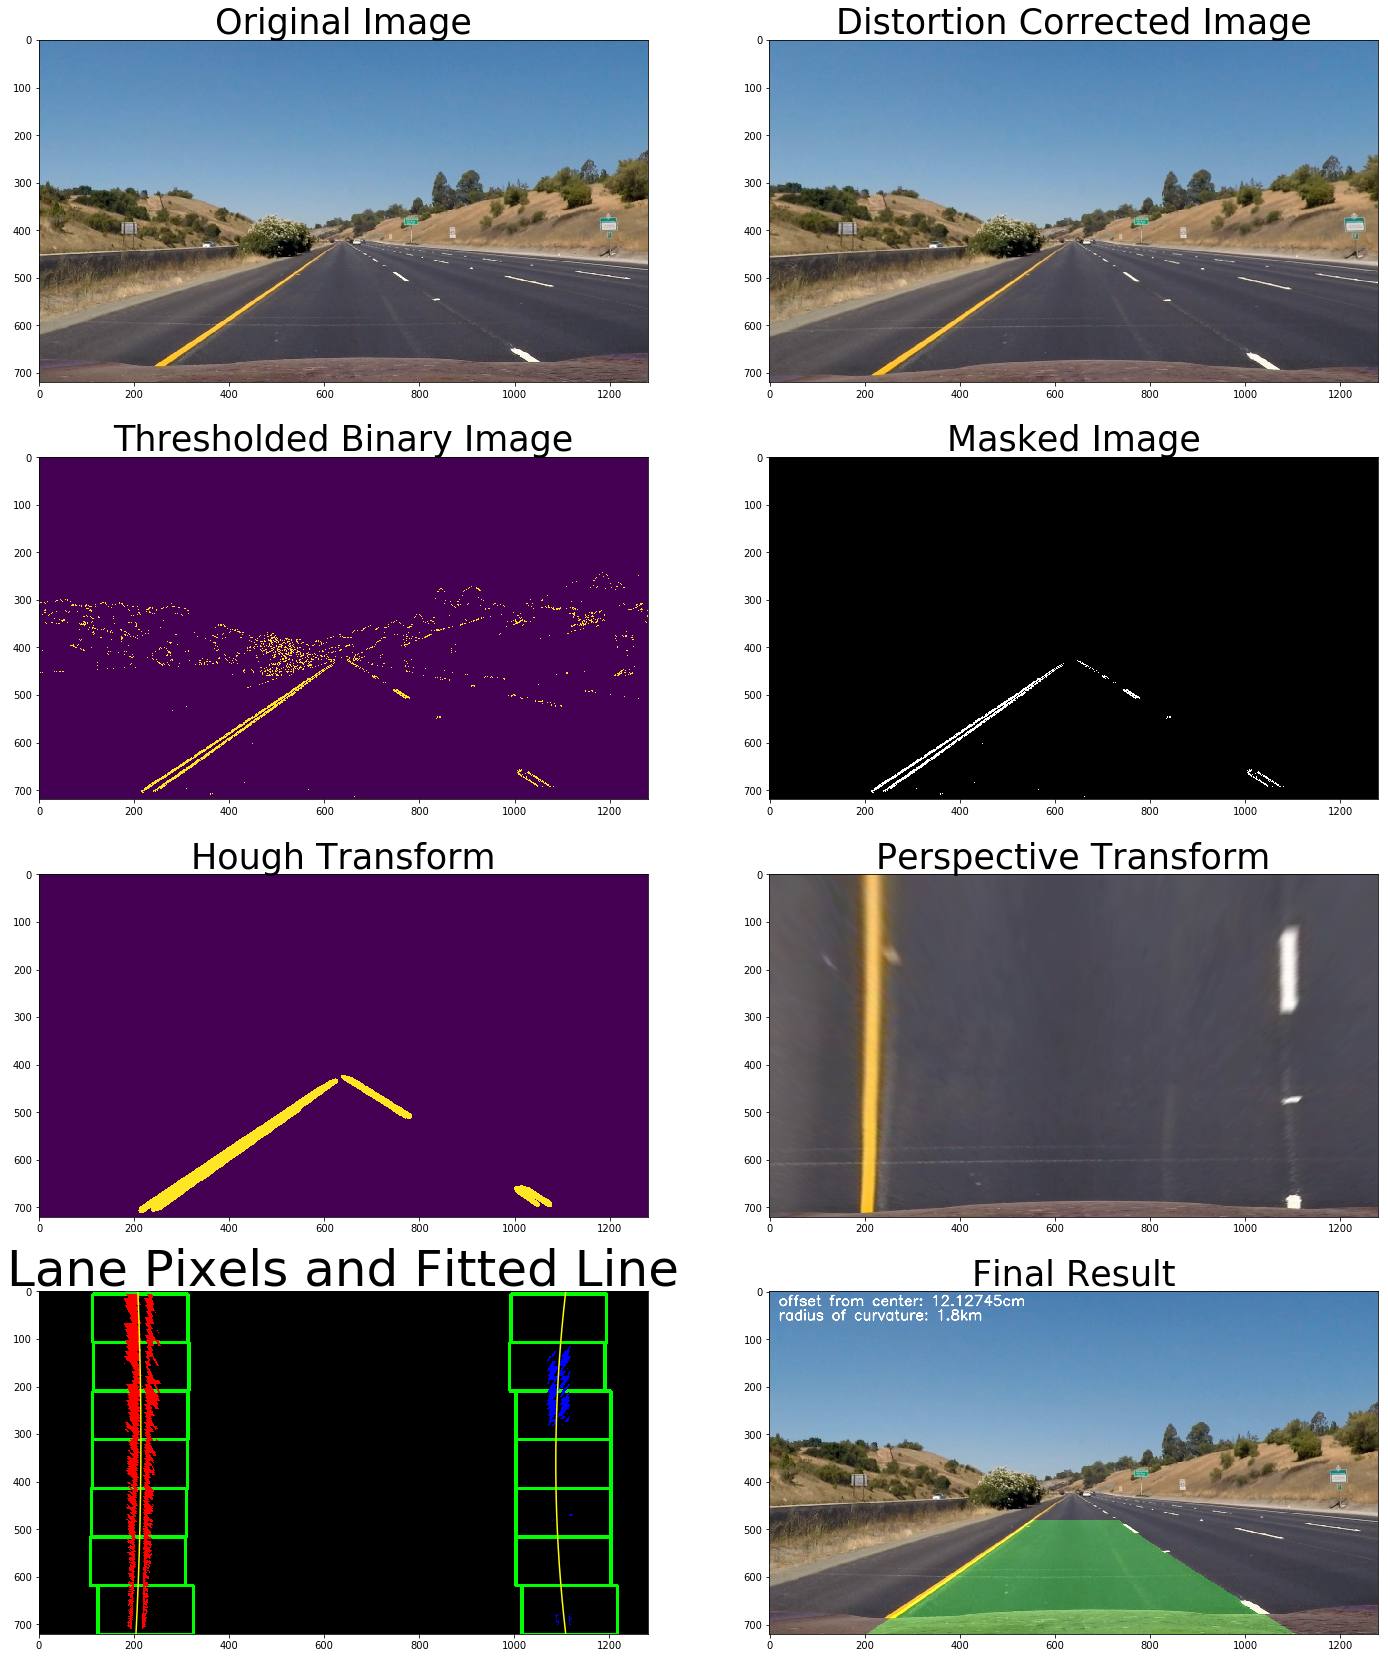

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


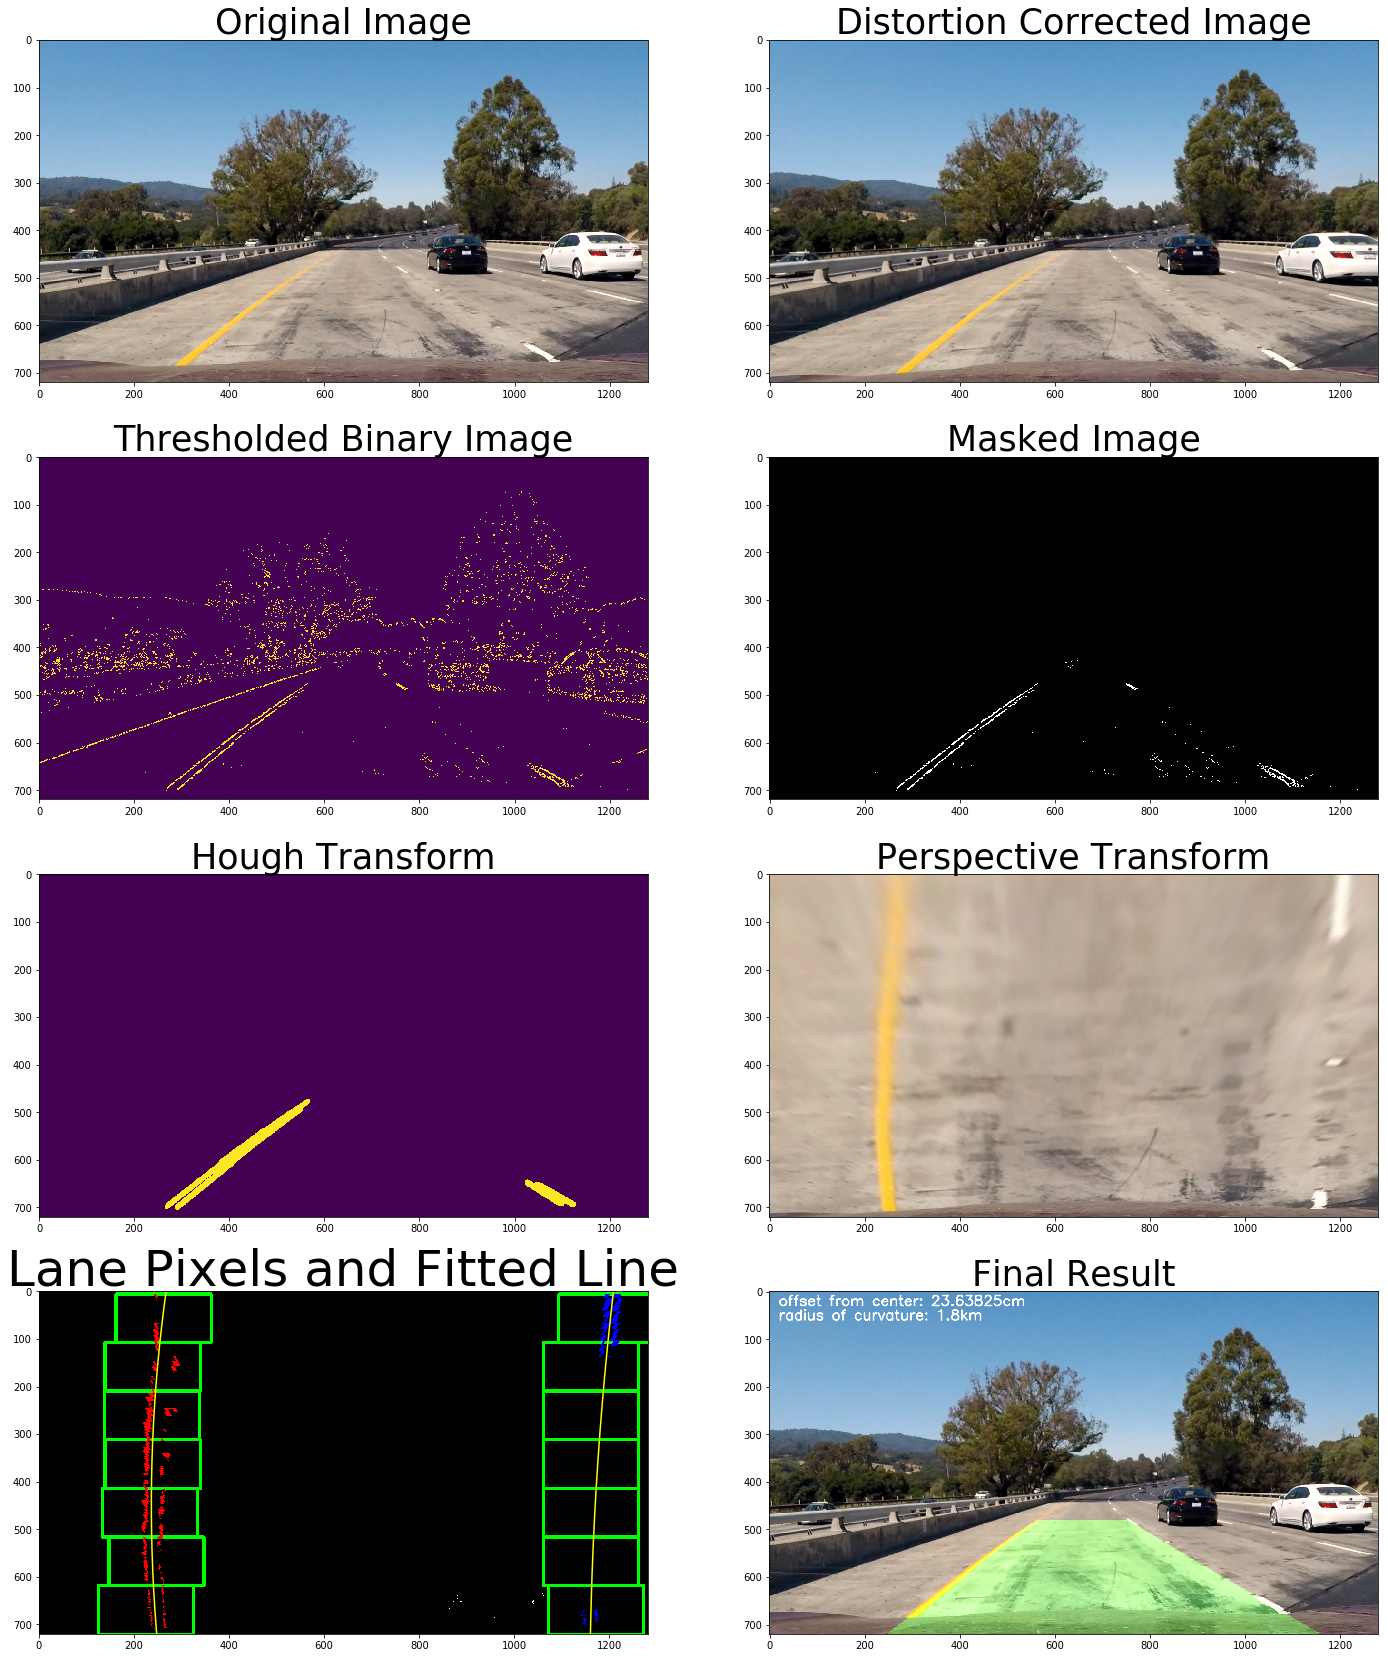

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


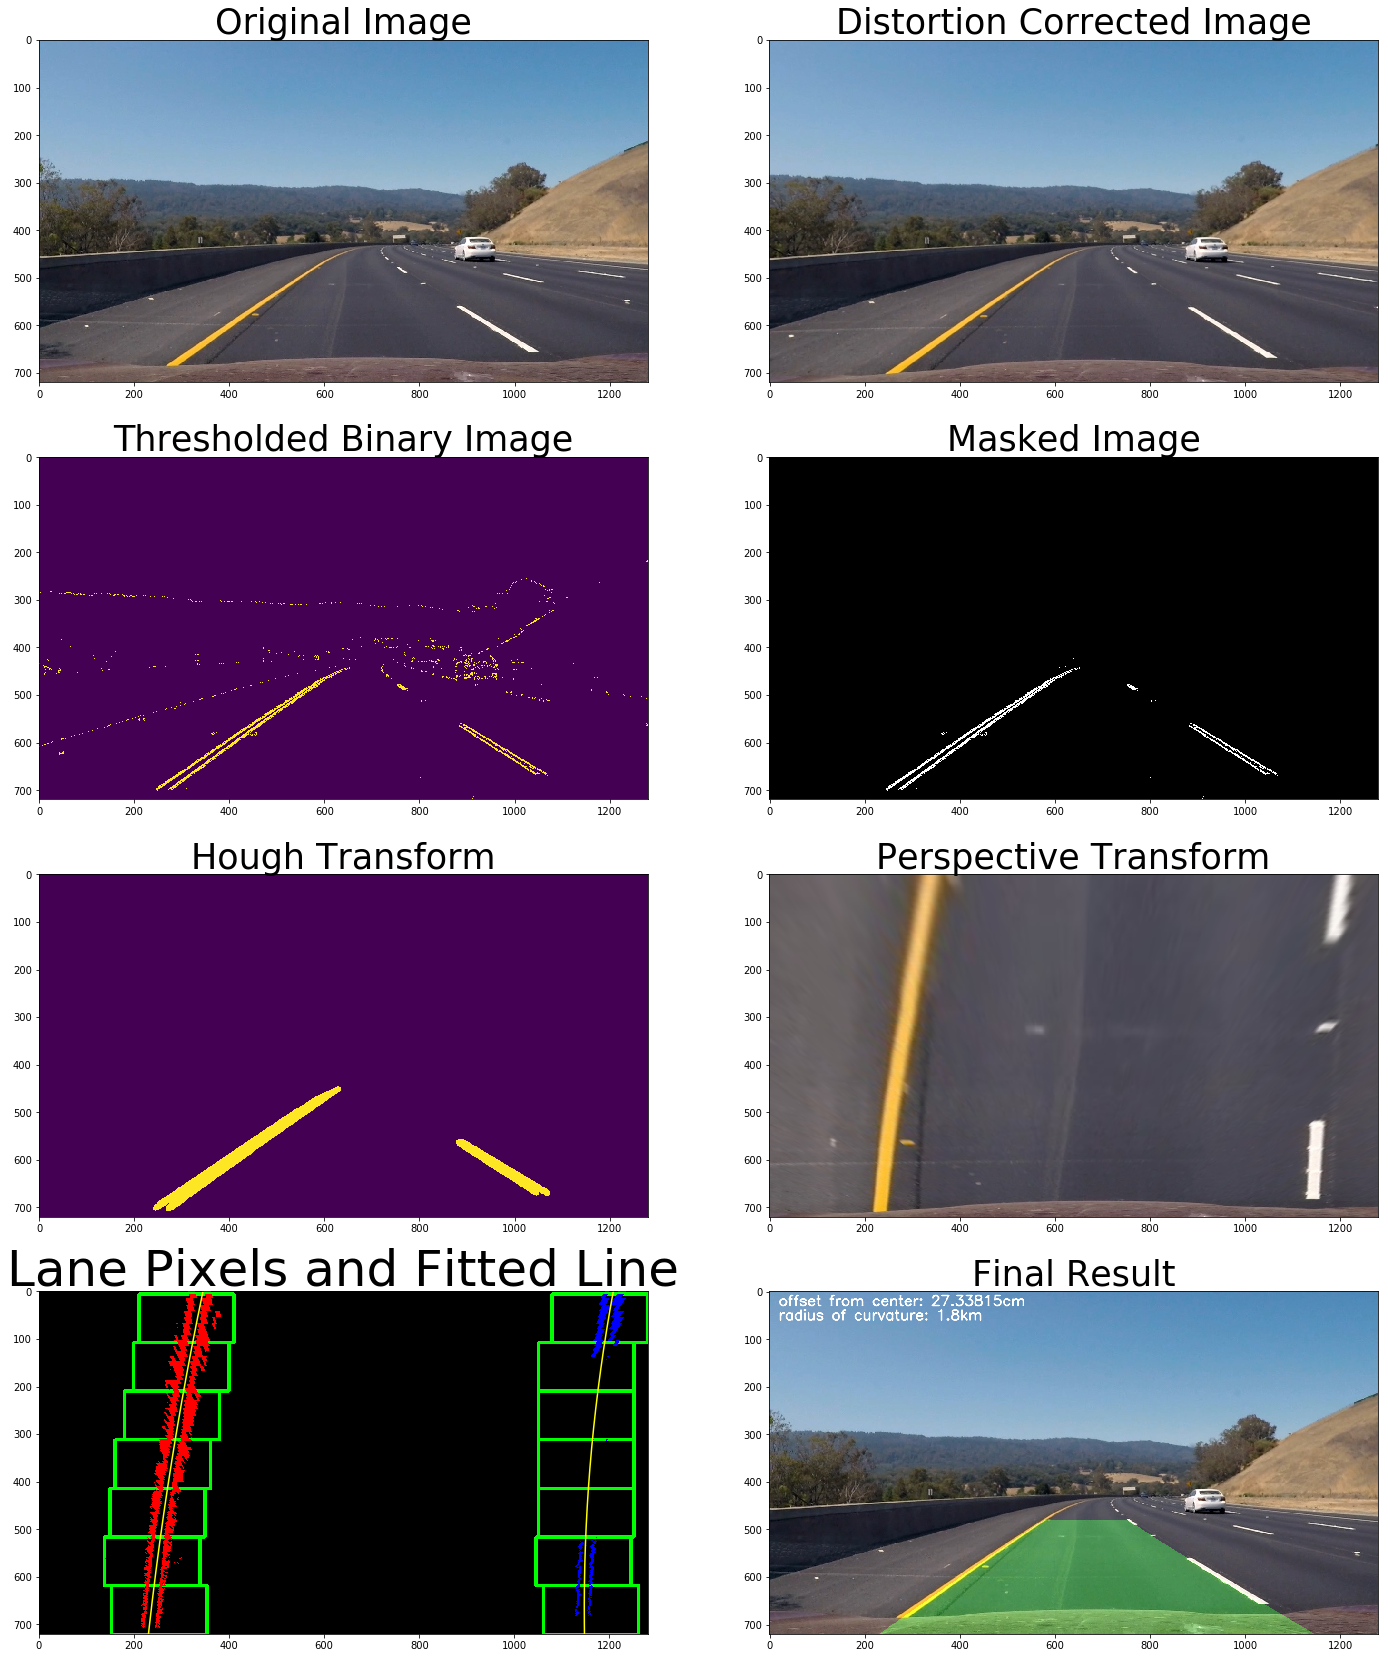

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


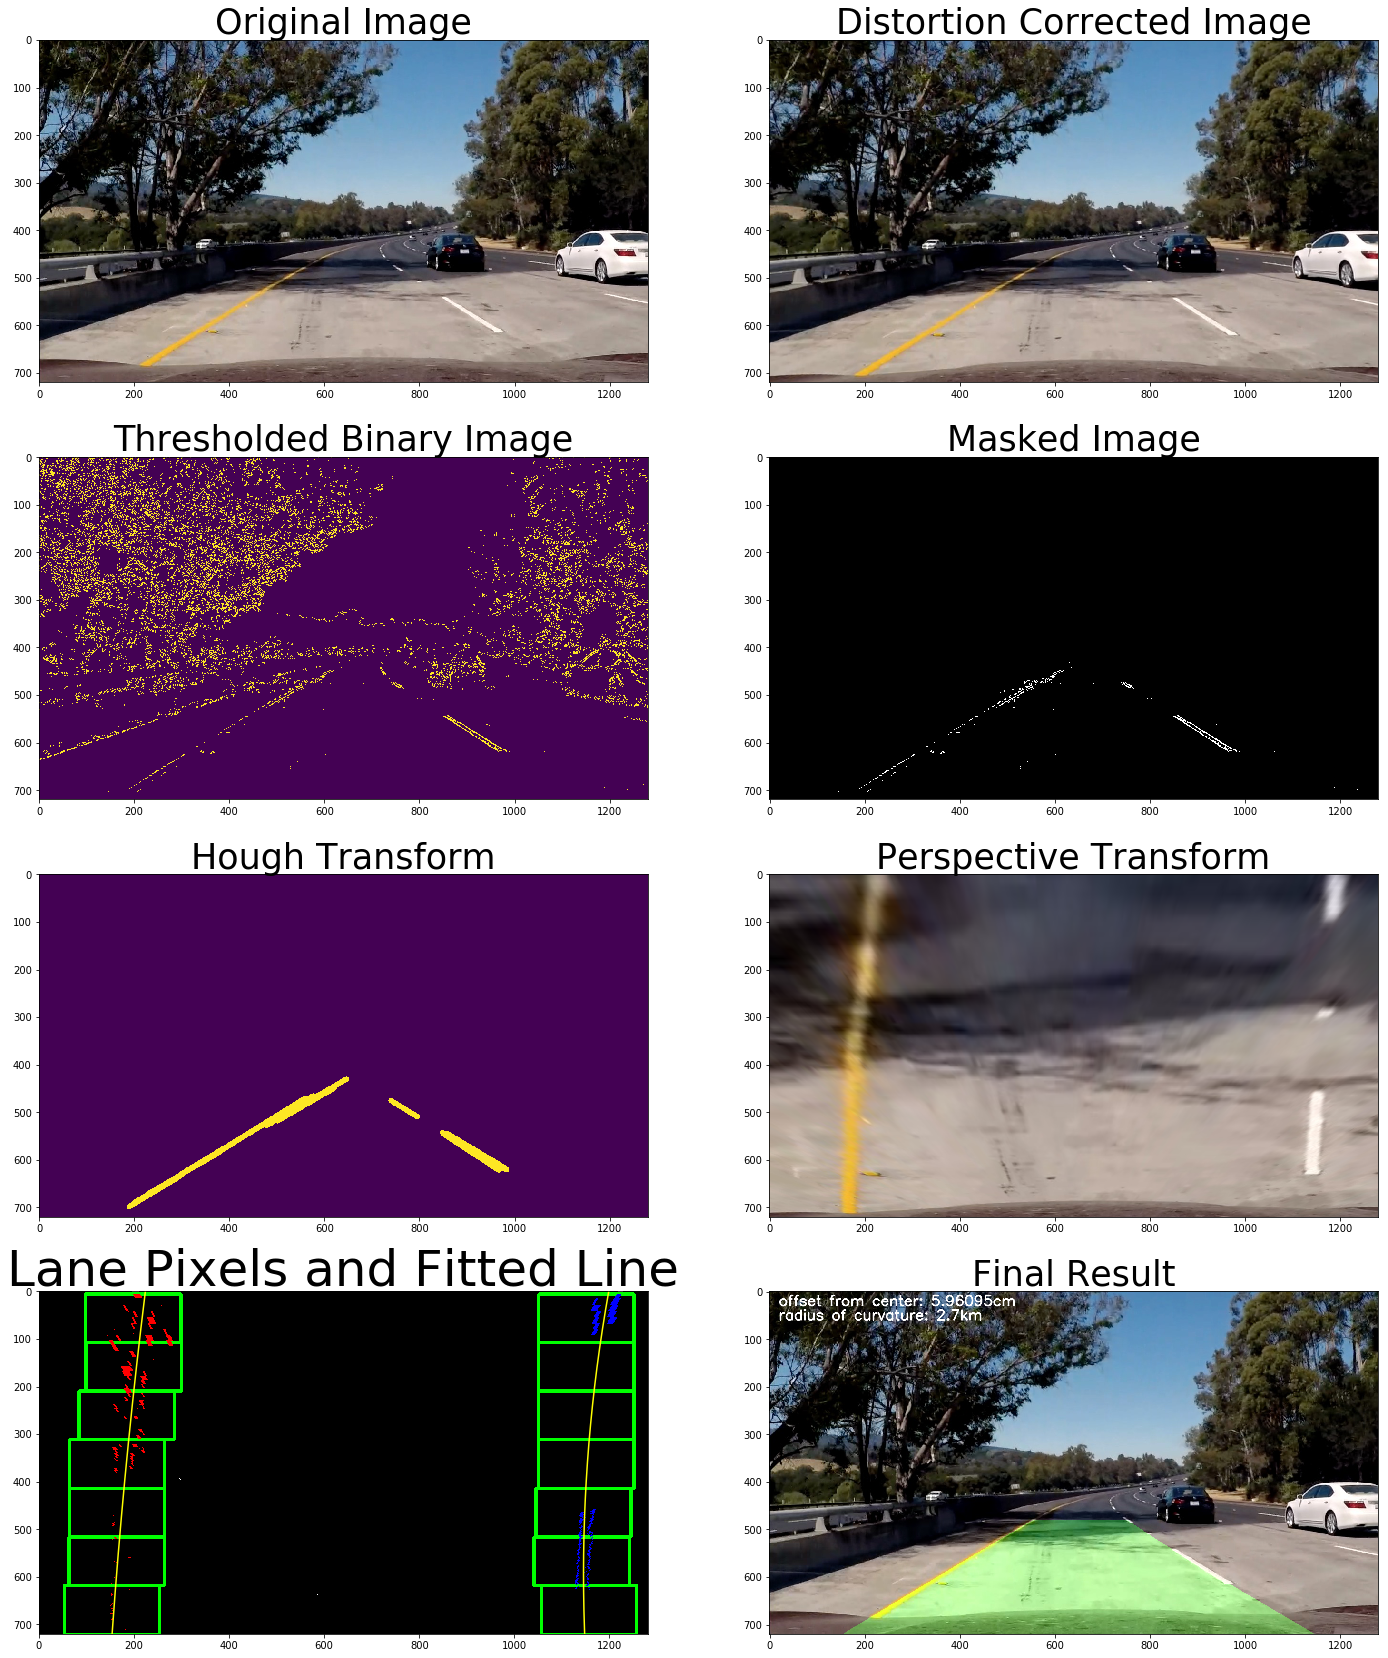

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [18]:
# List Files for Load Directory
os.chdir("E:/CarND-Advanced-Lane-Lines")
test_list = os.listdir("test_images/")

# Load Camera Distortion Matrix
dist_pickle = pickle.load( open( "camera_cal/camera_cal.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Set Threshold Parameters
channel = 'sat'
ksize = 3 # Choose a larger odd number to smooth gradient measurements
thresh = (50, 175)
mag_thresh = (50, 175)
dir_thresh=(0.7, 1.3)

# Save Original Working Directory
owd = os.getcwd()

for test_image in test_list:
    
    f,([ax1,ax2],[ax3,ax4],[ax5,ax6],[ax7,ax8]) = plt.subplots(4,2, figsize=(24, 30), gridspec_kw={'hspace':0.1})
    
    # Read in Original Image
    my_file_1 = test_image
    image = mpimg.imread('test_images/'+"%s"%(my_file_1))
    img_size = (image.shape[1], image.shape[0])
    
    # Set Image Output Directories
    write_dir = "E:/CarND-Advanced-Lane-Lines/output_images/{}".format(my_file_1.split('.')[0])
    if not os.path.exists(write_dir):
        os.makedirs(write_dir)
    os.chdir(write_dir)
    
    # Show Original Image in Subplot
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=35)
    mpimg.imsave('Original_Image.jpg',image)
    
    # Distortion Correction
    distort = DistortionCorrection(image, mtx, dist)
    ax2.imshow(distort)
    ax2.set_title('Distortion Corrected Image', fontsize=35)
    mpimg.imsave('Distortion Corrected Image.jpg',distort)

    # Thresholded Binary Image
    combined = combined_grad(distort, channel, ksize, thresh, mag_thresh, dir_thresh)
    ax3.imshow(combined)
    ax3.set_title('Thresholded Binary Image', fontsize=35)
    mpimg.imsave('Thresholded Binary Image.jpg',combined)    
    
    # Region of Interest
    len_y = img_size[1]
    len_x = img_size[0]
    vertices = np.array([[(0,len_y), (len_x/2,425), (len_x,len_y)]], dtype=np.int32)
    
    masked_image, mask = region_of_interest(combined, vertices)

    ax4.imshow(masked_image, cmap = 'gray')
    ax4.set_title('Masked Image', fontsize=35)
    mpimg.imsave('Masked Image.jpg',masked_image)
    
    # Hough Transform Parameters + Call
    rho = 1
    theta = np.pi/180
    threshold = 50
    min_line_len = 30
    max_line_gap = 40
    line_image = np.copy(masked_image)*0
    center = masked_image.shape[1]/2
    
    left_lane_line, right_lane_line, line_image = Hough_Trans(masked_image, rho, theta, threshold, min_line_len, max_line_gap, center, line_image)
    
    color_edges = masked_image
    combo = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0)
    ax5.imshow(combo)
    ax5.set_title('Hough Transform', fontsize=35)
    mpimg.imsave('Hough Transform.jpg', combo)
    
    # Perspective Transform
    src, dst = source()
    
    top_down_org, M, Minv = corners_unwarp(distort, src, dst, mtx, dist, img_size)
    top_down_org = top_down_org.astype(dtype='uint8')
    
    top_down, M, Minv = corners_unwarp(combined, src, dst, mtx, dist, img_size)
    top_down = top_down.astype(dtype='uint8')
    
    ax6.imshow(top_down_org)
    ax6.set_title('Perspective Transform', fontsize=35)
    mpimg.imsave('Perspective Transform.jpg',top_down_org)
    
    # Identify Lane Pixels and Fit Line
    left_fit, right_fit, leftx, lefty, rightx, righty, out_img = find_lines(top_down)
    
    ploty, left_fitx, right_fitx = linefit(top_down, left_fit, right_fit)
    
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    ax7.plot(left_fitx, ploty, color='yellow')
    ax7.plot(right_fitx, ploty, color='yellow')
    ax7.set_xlim([0, 1280])
    ax7.set_ylim([720, 0])
    ax7.set_title('Lane Pixels and Fitted Line', fontsize=50)
    ax7.imshow(out_img)
    mpimg.imsave('Lane Pixels and Fitted Line.jpg',out_img)
    
    # Measuring Curavture and Offset
    
    leftcurve, rightcurve = Curvature(ploty, left_fitx, right_fitx)
    offset = Offset(top_down)
    
    # Map Marked Lane, Curvature, and OFfset to Original Image
    result = drawing(image, top_down, left_fitx, right_fitx, ploty, Minv)
    Caption(result, offset, leftcurve, rightcurve)
    ax8.imshow(result)
    ax8.set_title('Final Result', fontsize=35)
    mpimg.imsave('Final Result.jpg',result)
    
    os.chdir(owd)